In [1]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from ibllib.atlas import AllenAtlas
from brainbox.core import TimeSeries
from brainbox.processing import bin_spikes

import numpy as np
import pandas as pd

## EDA

In [2]:
pw = 'international'
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password=pw, silent=True)
ba = AllenAtlas()
pid = 'da8dfec1-d265-44e8-84ce-6ae9c109b8bd'

In [3]:
sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)
trials = one.load_object('SWC_043/2020-09-21/001', 'trials', collection='alf')

In [4]:
spikes

{'amps': array([1.12502950e-04, 1.69044700e-04, 7.31735374e-05, ...,
        6.32226820e-05, 8.56651966e-05, 1.58687280e-04]),
 'clusters': array([639, 518, 208, ...,  36, 258,  99], dtype=uint32),
 'times': array([5.48913109e-03, 8.12244216e-03, 1.18557439e-02, ...,
        4.29594537e+03, 4.29594561e+03, 4.29594777e+03]),
 'depths': array([3540.57568359, 3132.62036133, 1634.10498047, ...,  293.59072876,
        2001.93505859,  865.07281494])}

In [5]:
# the channels are the physicals probes of the neuropixels. There are 384 probes, hence 384 channels
channels['x'].shape

(384,)

In [6]:
spikes['clusters'][spikes['clusters']==1].shape

(36216,)

In [7]:
spikes['times'].max()

4295.947773915647

In [8]:
spikes['depths'][spikes['clusters']==40.21386719]

array([], dtype=float64)

In [9]:
clusters.keys()

dict_keys(['depths', 'uuids', 'channels', 'cluster_id', 'amp_max', 'amp_min', 'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt', 'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio', 'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate', 'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um'])

In [10]:
for i in clusters:
    print(i, ": ", clusters[i][:5])

depths :  [20. 20. 20. 40. 40.]
uuids :  0    eabfbc37-3a64-4eed-b572-0a64db35612a
1    42b7ac0c-e8ae-4a35-99cd-60d270a9cd6f
2    56e57b59-9778-4f6f-9641-77b53a30e98c
3    01392abf-909f-4b05-b004-30db61cbaa99
4    54677eeb-5d38-417d-83b3-7c42eb9ec431
Name: uuids, dtype: object
channels :  [0 0 1 3 3]
cluster_id :  [0 1 2 3 4]
amp_max :  [0.00030135 0.00026349 0.00018865 0.0001384  0.00011936]
amp_min :  [1.23242538e-04 7.65254288e-05 7.30344541e-05 5.74085121e-05
 7.59452488e-05]
amp_median :  [2.06488298e-04 1.50695985e-04 8.47766188e-05 7.39944238e-05
 9.26102445e-05]
amp_std_dB :  [1.28520445 2.07737145 1.10484648 1.26433161 1.82074254]
contamination :  [0.         0.00116977 0.05015565 0.         0.        ]
contamination_alt :  [0.         0.00108176 0.04511687 0.         0.        ]
drift :  [3.32306610e+04 2.11527772e+05 9.37797398e+05 1.57938024e+05
 4.85449360e+01]
missed_spikes_est :  [0.00209059 0.04441329 0.5        0.25724096        nan]
noise_cutoff :  [ -0.54073807   1.6

In [11]:
trials.keys()

dict_keys(['goCueTrigger_times', 'stimOff_times', 'probabilityLeft', 'feedbackType', 'response_times', 'choice', 'firstMovement_times', 'contrastLeft', 'contrastRight', 'stimOn_times', 'rewardVolume', 'feedback_times', 'goCue_times', 'intervals'])

(<Figure size 1600x900 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-09-21_1_SWC_043_probe00, da8dfec1-d265-44e8-84ce-6ae9c109b8bd \n17_575_242 spikes, 914 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

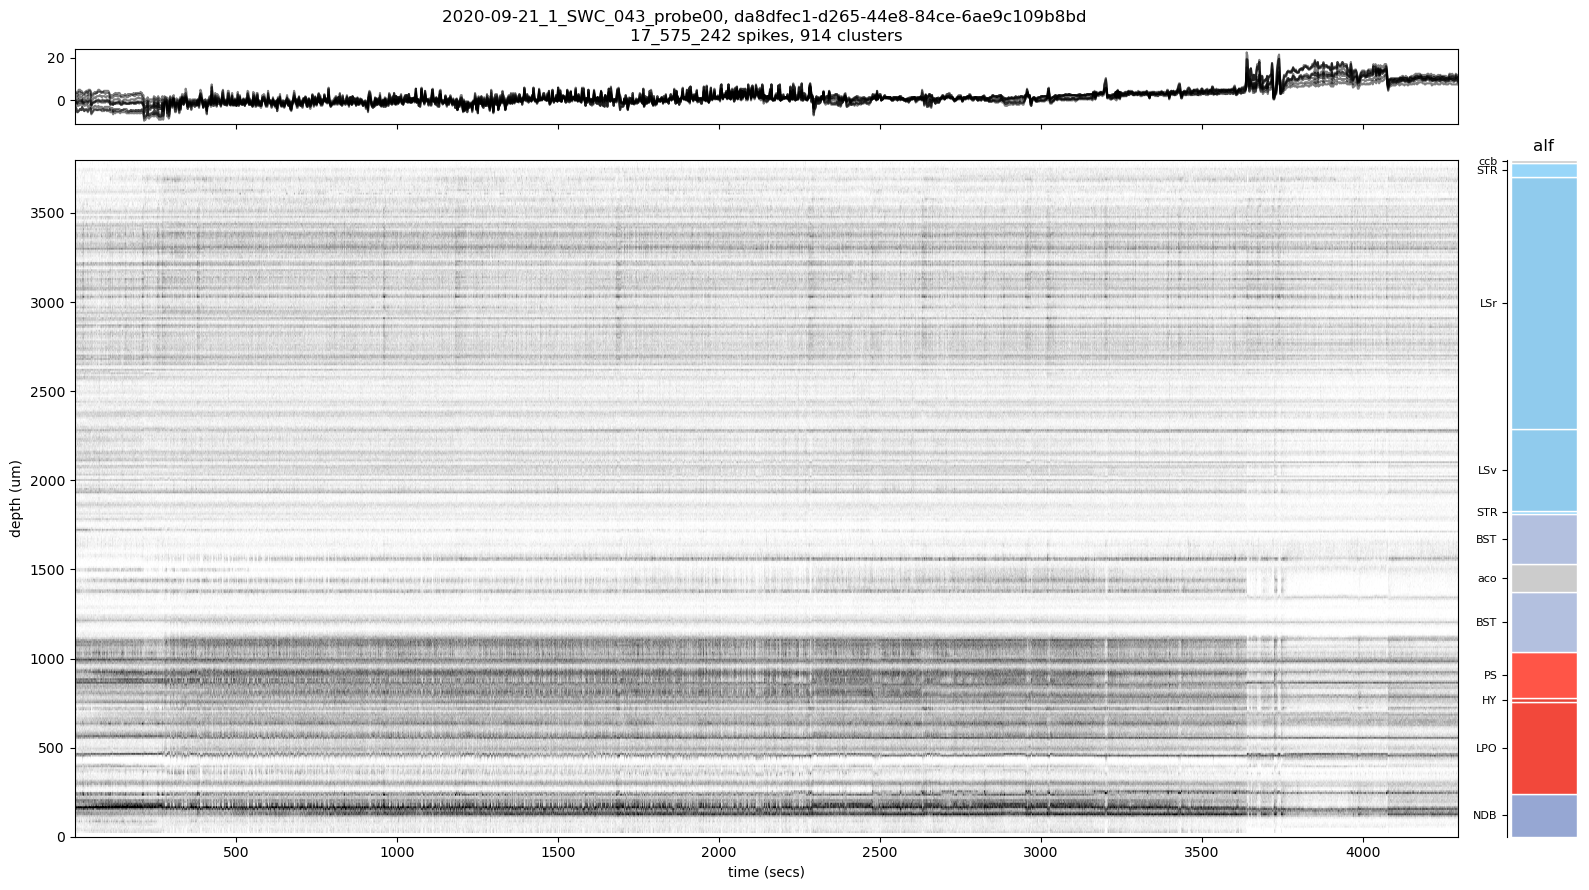

In [12]:
sl.raster(spikes, channels)

### Data Cleaning
1) Filter data for only good clusters (should indicate single neurons)
2) Split data across trials
3) Bin spike times for each neuron, for each trial

In [13]:
good_clusterIDs = clusters['cluster_id'][clusters['label'] == 1] # Find good clusters
good_cluster_loc = np.isin(spikes['clusters'], good_clusterIDs)

In [14]:
good_spikes = {}
for i in spikes:
    good_spikes[i] = spikes[i][good_cluster_loc]

In [15]:
good_spikes

{'amps': array([1.12502950e-04, 1.69044700e-04, 7.31735374e-05, ...,
        2.02525975e-04, 1.10336245e-04, 1.58687280e-04]),
 'clusters': array([639, 518, 208, ...,  99, 114,  99], dtype=uint32),
 'times': array([5.48913109e-03, 8.12244216e-03, 1.18557439e-02, ...,
        4.29593914e+03, 4.29593941e+03, 4.29594777e+03]),
 'depths': array([3540.57568359, 3132.62036133, 1634.10498047, ...,  894.89599609,
         918.56298828,  865.07281494])}

(<Figure size 1600x900 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-09-21_1_SWC_043_probe00, da8dfec1-d265-44e8-84ce-6ae9c109b8bd \n4_139_263 spikes, 165 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

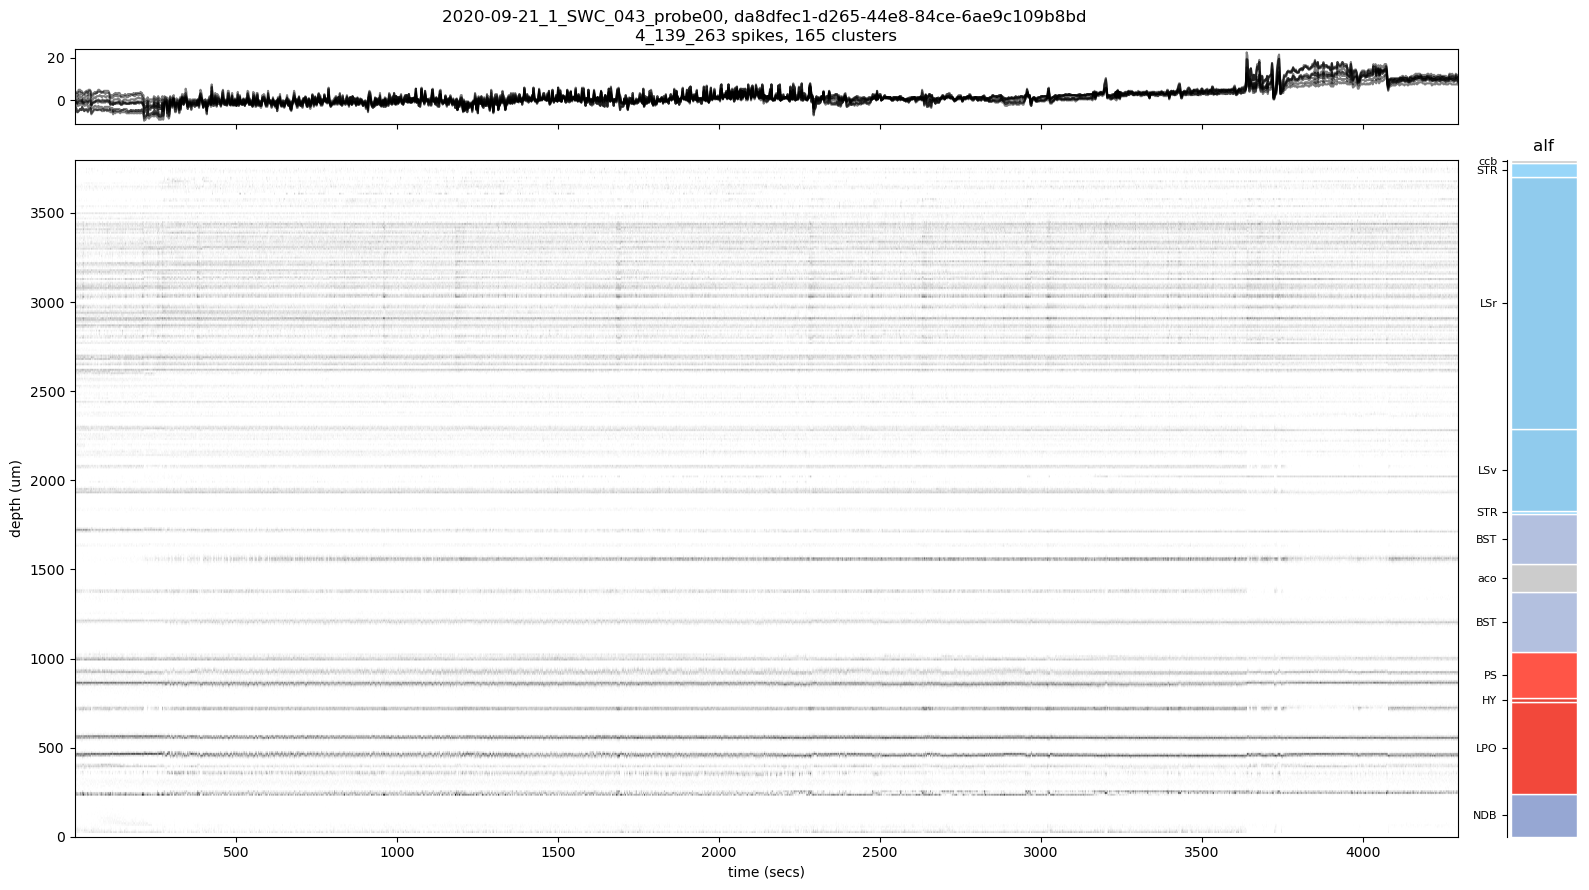

In [16]:
sl.raster(good_spikes, channels)

In [17]:
trials['intervals']

array([[ 266.15101557,  272.30825959],
       [ 272.71315929,  277.05830784],
       [ 277.53001089,  279.87603759],
       ...,
       [2952.64627887, 2957.90602276],
       [2958.71662607, 2966.97139324],
       [2967.84479703, 2985.18913487]])

In [18]:
# good_spikes
# All trials must have the same number of neurons
df = pd.DataFrame(data = {'clusters':good_spikes['clusters'], 'times':good_spikes['times']})
df = df.groupby('clusters')['times'].apply(np.array)
df

clusters
0      [209.12262990663282, 209.51279330259365, 212.4...
1      [0.1517878943612596, 0.17438770331575443, 0.17...
6      [8.37271839944542, 19.70735591641346, 20.54201...
35     [0.014489055004970183, 0.0210223331098094, 0.0...
37     [0.14105465176045232, 0.2822867912002674, 0.43...
                             ...                        
830    [1.7863407434786094, 4.500484466369084, 4.5077...
856    [4.758082288788458, 15.148494454349457, 18.347...
861    [110.12356076326957, 116.75200504126173, 120.8...
869    [2.1751707898712085, 6.305402541985583, 10.157...
913    [0.9213480556185195, 2.611633766936334, 5.3863...
Name: times, Length: 165, dtype: object

In [19]:
trials_spikes = [] # The Spike times and results of each trial

for i in range(len(trials['goCueTrigger_times'])):
    spike_range = {}
    
    spike_range['goCue_times'] = trials['goCue_times'][i]
    spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
    spike_range['choice'] = trials['choice'][i]
    spike_range['feedbackType'] = trials['feedbackType'][i]
    
    x = []
    try:
        hist_bins = np.arange(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i], 0.01) # 10ms bins
    except:
        continue
        # the hist bins throw an error if the first movement time is NaN
        # print(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i])
    
    for j in df:
        inds = ((j>trials['goCueTrigger_times'][i]) & (j<=trials['firstMovement_times'][i])) # From go queue to first movement
        # print(np.histogram(j[inds], hist_bins)[0])
        x.append(np.histogram(j[inds], hist_bins)[0])
    
    spikes_df = pd.DataFrame(x, index=df.index)
    spike_range['spikes_df'] = spikes_df
    
    trials_spikes.append(spike_range)

In [20]:
trials_spikes[10]["spikes_df"]

,0,1,2,3,4,5,6,7,8,9,...,204,205,206,207,208,209,210,211,212,213
clusters,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,1,1
37,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
856,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
861,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# trials_spikes = [] # The Spike times and results of each trial

# for i, interval in enumerate(trials['intervals']):
#     time_range = ((good_spikes['times']>interval[0]) & (good_spikes['times']<interval[1])) #Find the spikes corresponding to the current interval
#     spike_range = {}
    
#     for key in good_spikes:
#         spike_range[key] = good_spikes[key][time_range]
        
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
    
#     # Bin Spikes based on time= 0.1 seconds, per cluster
#     df = pd.DataFrame(data={'clusters':spike_range['clusters'], 'times':spike_range['times']})
#     hist_bins = np.arange(interval[0], interval[1], 0.1)
#     df = df.groupby('clusters')['times'].apply(list)
    
#     hist_rows = []
#     for i in df.iloc:
#         hist_rows.append(np.histogram(i, hist_bins)[0])
#     spikes_df = pd.DataFrame(hist_rows, columns=hist_bins[:-1], index=df.index) # Clusters are assumed to be good neurons
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

In [22]:
trials_spikes[2]['spikes_df']

""
clusters
0
1
6
35
37
...
830
856
861


In [23]:
trials_spikes[3]['spikes_df']

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
clusters,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,1,0
37,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
856,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


KeyError: 'times'

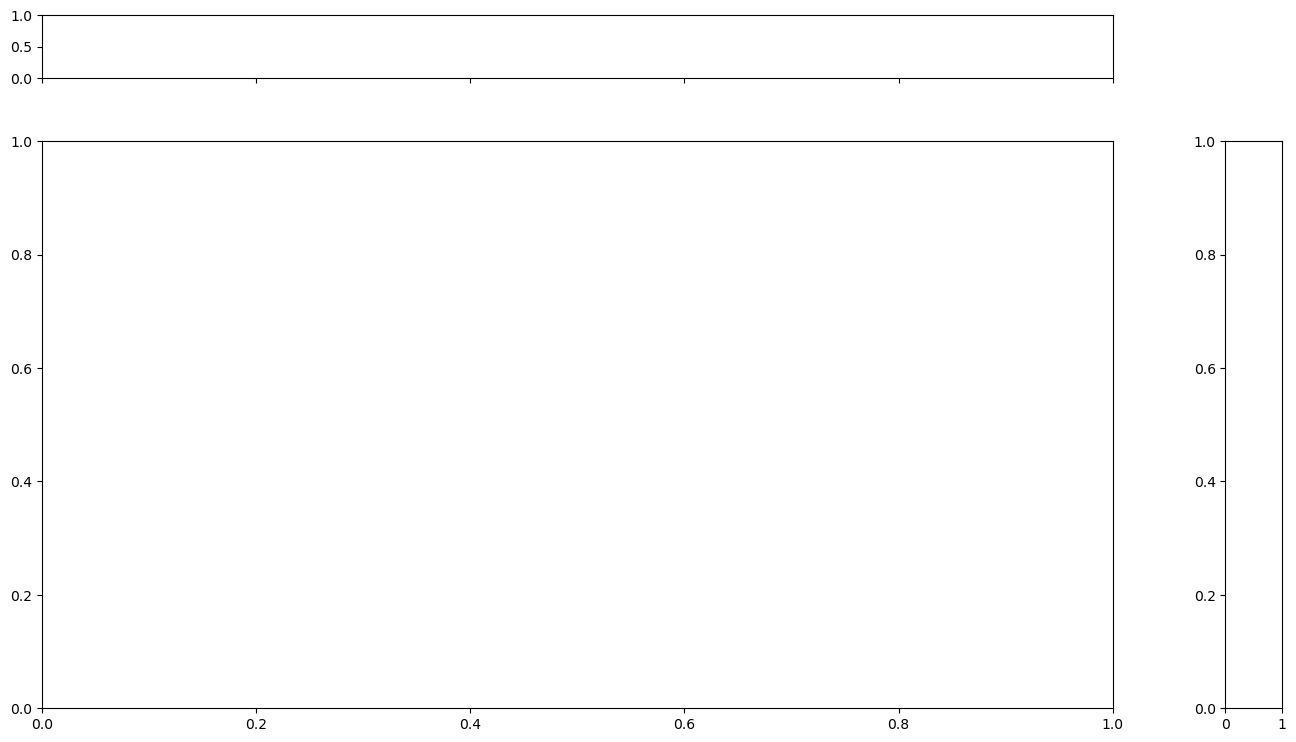

In [24]:
sl.raster(trials_spikes[3], channels)

In [25]:
import math

import jax.random
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from vlgpax.model import Session
from vlgpax.kernel import RBF, RFF
from vlgpax import vi

In [ ]:
trials_spikes[2]['spikes_df'].T

clusters,0,1,6,35,37,38,44,51,53,54,...,792,793,804,812,821,826,830,856,869,913
277.530011,0,1,0,3,1,0,0,2,0,10,...,0,0,0,0,0,2,0,2,0,1
277.630011,0,2,0,2,0,0,0,2,0,8,...,0,0,0,0,0,2,1,0,1,0
277.730011,0,1,0,2,1,0,0,0,0,7,...,2,0,0,0,0,1,0,0,0,0
277.830011,0,4,0,3,1,0,0,3,0,9,...,0,0,0,0,0,2,0,1,0,0
277.930011,0,0,0,1,0,0,0,2,0,4,...,0,0,0,0,0,2,0,3,0,0
278.030011,0,0,0,5,1,0,4,1,0,7,...,0,0,1,0,0,1,1,2,0,0
278.130011,0,0,0,7,1,0,3,0,0,5,...,0,1,0,0,0,1,0,0,0,0
278.230011,0,0,0,11,2,0,3,0,0,4,...,0,0,1,0,1,2,0,0,0,0
278.330011,0,1,0,12,1,0,1,0,0,4,...,0,0,2,1,0,2,0,0,1,0
278.430011,0,1,0,8,0,0,0,0,0,3,...,0,0,1,0,1,1,0,0,0,0


In [26]:
session = Session(0.1)
# y = pd.read_csv("neural_data.csv")
# session.add_trial(0, y=y)
for i, trial in enumerate(trials_spikes):
    if trial['spikes_df'].shape[1] > 20: # Must have at least 20 timepoints
        session.add_trial(i, y=trial['spikes_df'].T)
    if i>20: break

In [27]:
kernel = RBF(scale=1., lengthscale=5)

In [28]:
session, params = vi.fit(session, n_factors=2, kernel=kernel, seed=0, max_iter=5, trial_length=20, GPFA=False)

21 20
143 20
47 20
214 20
21 20
34 20
94 20
244 20
Initializing
Initialized


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:267: UserWarning: M: loss increased
  warnings.warn('M: loss increased')


EM Iteration 1, 	Loss = 23.7125, 	M step: 1.80s, 	E step: 1.84s
EM Iteration 2, 	Loss = 22.1815, 	M step: 0.37s, 	E step: 0.75s


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:267: UserWarning: M: loss increased
  warnings.warn('M: loss increased')
c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


EM Iteration 3, 	Loss = 22.1371, 	M step: 0.38s, 	E step: 0.89s
EM Iteration 4, 	Loss = 22.1117, 	M step: 0.33s, 	E step: 1.00s
EM Iteration 5, 	Loss = 59.1913, 	M step: 0.54s, 	E step: 1.17s
Inferring


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:406: UserWarning: EM: loss increased
  warnings.warn('EM: loss increased')


Trial 0, 	Loss = 26.0605


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:170: UserWarning: E: maximum number of iterations reached
  warnings.warn(f'E: maximum number of iterations reached')


Trial 3, 	Loss = 22.7455


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


Trial 6, 	Loss = 20.7323


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


Trial 10, 	Loss = 23.3563
Trial 11, 	Loss = 28.0559


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


Trial 12, 	Loss = 23.5693


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


Trial 15, 	Loss = 21.6014


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


Trial 19, 	Loss = 19.1622
Finished


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:170: UserWarning: E: maximum number of iterations reached
  warnings.warn(f'E: maximum number of iterations reached')


In [74]:
# trials_spikes[2]['spikes_df'].T.to_csv("neural_data.csv")

In [33]:
session2 = Session(0.1)
# y = pd.read_csv("neural_data.csv")
# session.add_trial(0, y=y)
session2.add_trial(i, y=trials_spikes[6]['spikes_df'].T)
session2 = vi.infer(session2, params=params)

Trial 21, 	Loss = 20.7323


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


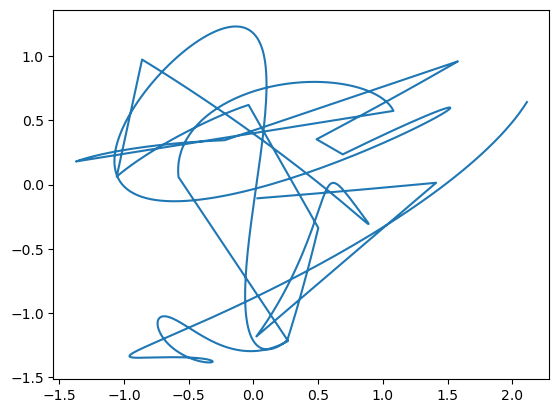

In [34]:
plt.plot(session.z[:, 0], session.z[:, 1])

In [117]:
session.z.shape

(31160, 2)